**Importing Dataset From The Google Drive**

In [1]:
import tensorflow
print(tensorflow.__version__)

2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Managing GPU & RAM**

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

**Libraries Import**

In [4]:
# import the libraries as shown below

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping


from tensorflow.keras.models import Sequential
from collections import Counter
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob

import tensorflow as tf
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import ast #to easily read out class text file that contains some unknwn syntax.
import scipy   #to upscale the image
import matplotlib.pyplot as plt
import cv2
from PIL import Image

**Resize Images & Copy Dataset Path**

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224

train_path = '/content/drive/MyDrive/MRI BT2/Training'
validate_path = '/content/drive/MyDrive/MRI BT2/Validate'
test_path = '/content/drive/MyDrive/MRI BT2/Testing'

**Getting The Size of The Training Dataset**

In [6]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/MRI BT2/Training/*')
print(folders)

['/content/drive/MyDrive/MRI BT2/Training/meningioma', '/content/drive/MyDrive/MRI BT2/Training/glioma', '/content/drive/MyDrive/MRI BT2/Training/pituitary', '/content/drive/MyDrive/MRI BT2/Training/notumor']


**Image Data Generator**

In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

validate_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

**Training Dataset - Augmentation Rules**




In [8]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 color_mode = 'rgb',
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

Found 5621 images belonging to 4 classes.


**Validating Dataset - Augmentation Rules**




In [9]:
validate_set = test_datagen.flow_from_directory(validate_path,
                                                target_size = (224, 224),
                                                color_mode = 'rgb',
                                                batch_size = 32,
                                                class_mode = 'categorical',
                                                shuffle = True)

Found 701 images belonging to 4 classes.


**Testing Dataset - Augmentation Rules**




In [10]:
testing_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            color_mode = 'rgb',
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 701 images belonging to 4 classes.


**Labels**

In [11]:
labels = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validate_set.class_indices)
print('Test  :', testing_set.class_indices)

Train : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Valid : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test  : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Calculating Weights

In [12]:
def compute_weights(dataset):
  counter = Counter(dataset.classes)
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()}
  return class_weights

**VGG19 Model**

In [13]:
# Import the ResNet50 library as shown below and add preprocessing layer to the front of ResNet
# Here we will be using imagenet weights

inputs = layers.Input(shape = (img_height,img_width,3))
base_model = VGG19(include_top = False,
                   weights = "imagenet",
                   input_tensor = inputs,
                   input_shape = (img_height,img_width,3),
                   pooling = 'avg')




In [14]:
# view the structure of the model
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Transfer Learning - ImageNet Weights Are Kept The Same**

In [15]:
# our layers - you can add more if you want
base_output = base_model.output

x = layers.Dense(units = 1280, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 640, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)

outputs = layers.Dense(units = len(folders), activation = 'softmax', name = 'final_softmax')(x)

model_vgg19 = tf.keras.Model(inputs, outputs)

# Transfer Leraning
base_model.trainable = True

# Fine Tuning
#for layer in base_model.layers[:18]:
#    layer.trainable = False
#for layer in base_model.layers[18:]:
#    layer.trainable = True


model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Model Compiling = Loss, Optimizer & Metrics**

In [16]:
# tell the model what cost and optimization method to use
model_vgg19.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


**Fitting The Model**

In [17]:
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)

early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

## Compute weights :
class_weights = compute_weights(training_set)

# fit the model
# Run the cell. It will take some time to execute
training_history = model_vgg19.fit(
  training_set,
  validation_data=validate_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(validate_set),
  class_weight=class_weights,
  callbacks = callbacks_list)

model_vgg19.save("/content/drive/MyDrive/models/VGG19-TF")

Epoch 1/25
176/176 [==============================] - 756s 4s/step - loss: 4.2410 - accuracy: 0.3789 - val_loss: 1.3163 - val_accuracy: 0.3224 - lr: 0.0010
Epoch 2/25
176/176 [==============================] - 106s 600ms/step - loss: 2.2705 - accuracy: 0.5024 - val_loss: 1.0469 - val_accuracy: 0.5235 - lr: 0.0010
Epoch 3/25
176/176 [==============================] - 106s 603ms/step - loss: 1.8608 - accuracy: 0.6043 - val_loss: 0.9558 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 4/25
176/176 [==============================] - 105s 596ms/step - loss: 1.7153 - accuracy: 0.6458 - val_loss: 0.9264 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 5/25
176/176 [==============================] - 106s 598ms/step - loss: 1.5856 - accuracy: 0.6874 - val_loss: 0.7351 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 6/25
176/176 [==============================] - 105s 596ms/step - loss: 1.5412 - accuracy: 0.7038 - val_loss: 0.7502 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 7/25
176/176 [=============================

**Printing The Trained Model Metrics**

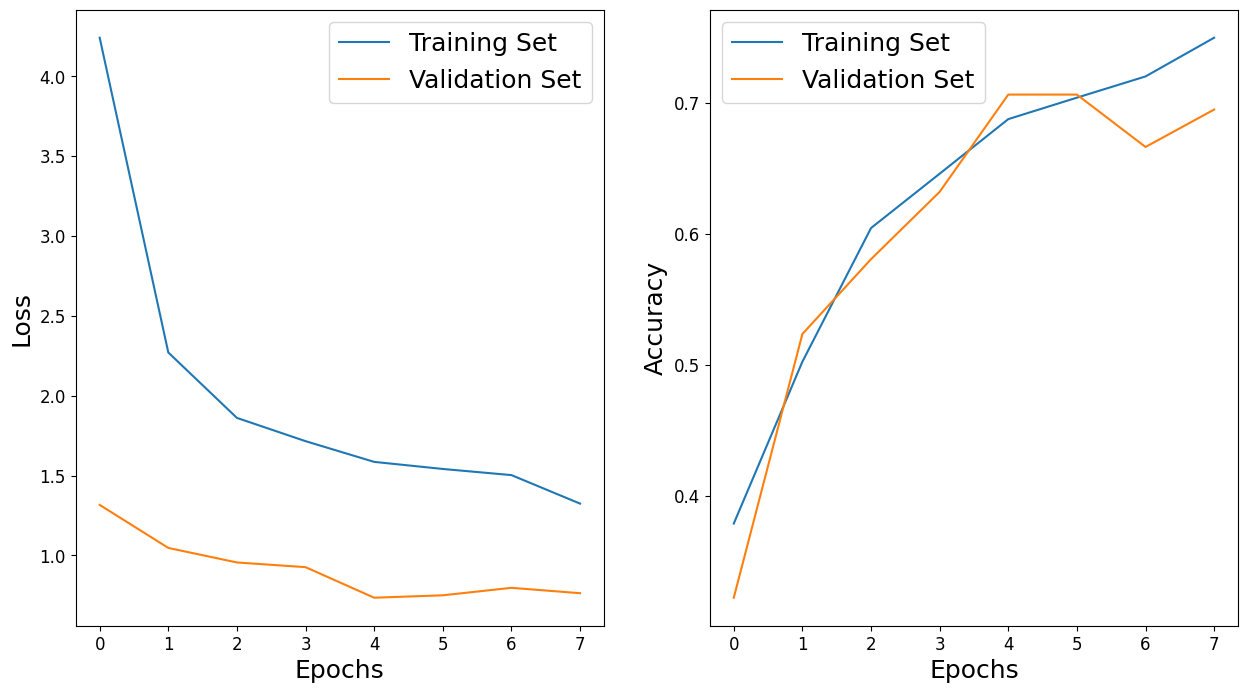

In [18]:
fig = plt.figure(figsize = (15,8))

fig.add_subplot(1,2,1)
plt.plot(training_history.history["loss"], label = 'Training Set')
plt.plot(training_history.history["val_loss"], label = 'Validation Set')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.legend(fontsize = 18)

fig.add_subplot(1,2,2)
plt.plot(training_history.history["accuracy"], label = 'Training Set')
plt.plot(training_history.history["val_accuracy"], label = 'Validation Set')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend(fontsize = 18)

**Fine Tuning**

In [19]:
# our layers - you can add more if you want
base_output = base_model.output

x = layers.Dense(units = 1280, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 640, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)

outputs = layers.Dense(units = len(folders), activation = 'softmax', name = 'final_softmax')(x)

model_vgg19 = tf.keras.Model(inputs, outputs)

# Transfer Leraning
# base_model.trainable = False

# Fine Tuning
for layer in base_model.layers[:18]:
    layer.trainable = False

for layer in base_model.layers[18:]:
    layer.trainable = True


model_vgg19.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [20]:
# tell the model what cost and optimization method to use
model_vgg19.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

**Fitting The Model**

In [21]:
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)

early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

## Compute weights :
class_weights = compute_weights(training_set)

# fit the model
# Run the cell. It will take some time to execute
training_history = model_vgg19.fit(
  training_set,
  validation_data=validate_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(validate_set),
  class_weight=class_weights,
  callbacks = callbacks_list)

model_vgg19.save("/content/drive/MyDrive/models/VGG19-FT")

Epoch 1/25
176/176 [==============================] - 91s 501ms/step - loss: 1.5834 - accuracy: 0.6956 - val_loss: 0.7717 - val_accuracy: 0.6776 - lr: 0.0010
Epoch 2/25
176/176 [==============================] - 86s 486ms/step - loss: 1.4873 - accuracy: 0.7230 - val_loss: 0.7784 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 3/25
176/176 [==============================] - ETA: 0s - loss: 1.4397 - accuracy: 0.7248
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
176/176 [==============================] - 88s 496ms/step - loss: 1.4397 - accuracy: 0.7248 - val_loss: 0.8410 - val_accuracy: 0.6591 - lr: 0.0010
Epoch 4/25
176/176 [==============================] - 86s 490ms/step - loss: 1.3113 - accuracy: 0.7586 - val_loss: 0.7516 - val_accuracy: 0.6947 - lr: 1.0000e-04
Epoch 5/25
176/176 [==============================] - 87s 492ms/step - loss: 1.3050 - accuracy: 0.7557 - val_loss: 0.8177 - val_accuracy: 0.6776 - lr: 1.0000e-04
Epoch 6/25
176/176 [====================

**Printing The Trained Model Metrics**

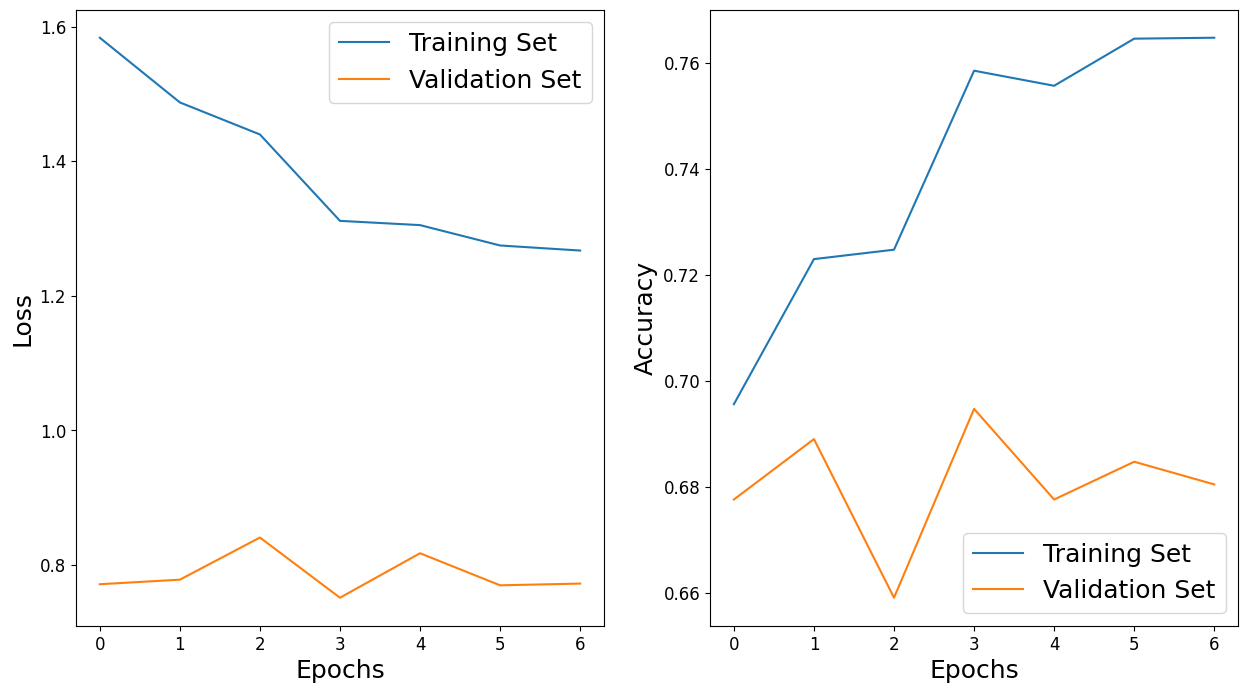

In [22]:
fig = plt.figure(figsize = (15,8))

fig.add_subplot(1,2,1)
plt.plot(training_history.history["loss"], label = 'Training Set')
plt.plot(training_history.history["val_loss"], label = 'Validation Set')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.legend(fontsize = 18)

fig.add_subplot(1,2,2)
plt.plot(training_history.history["accuracy"], label = 'Training Set')
plt.plot(training_history.history["val_accuracy"], label = 'Validation Set')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend(fontsize = 18)

## Loading The Model

In [23]:
model = load_model('/content/drive/MyDrive/models/VGG19-TF')

## Model Summary

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Model's Evaluation**

In [25]:
model.evaluate(testing_set)

22/22 [==============================] - 130s 6s/step - loss: 0.9003 - accuracy: 0.6619


[0.9002859592437744, 0.6619115471839905]

## Confusion Matrix

**Testing**

The blood cell images include 11 classes :

BNE : Banded NEutrophils
BA : BAsophils
EO : EOsinophils
ERB : ERythroBlasts
LY : LYmphocytes
MMY : MetaMYelocytes
MO : MOnocytes
MY : MYelocytes
PLT : PLaTelets
PMY : Promyelocytes
SNE : Segmented NEutrophils

22/22 [==============================] - 3s 129ms/step


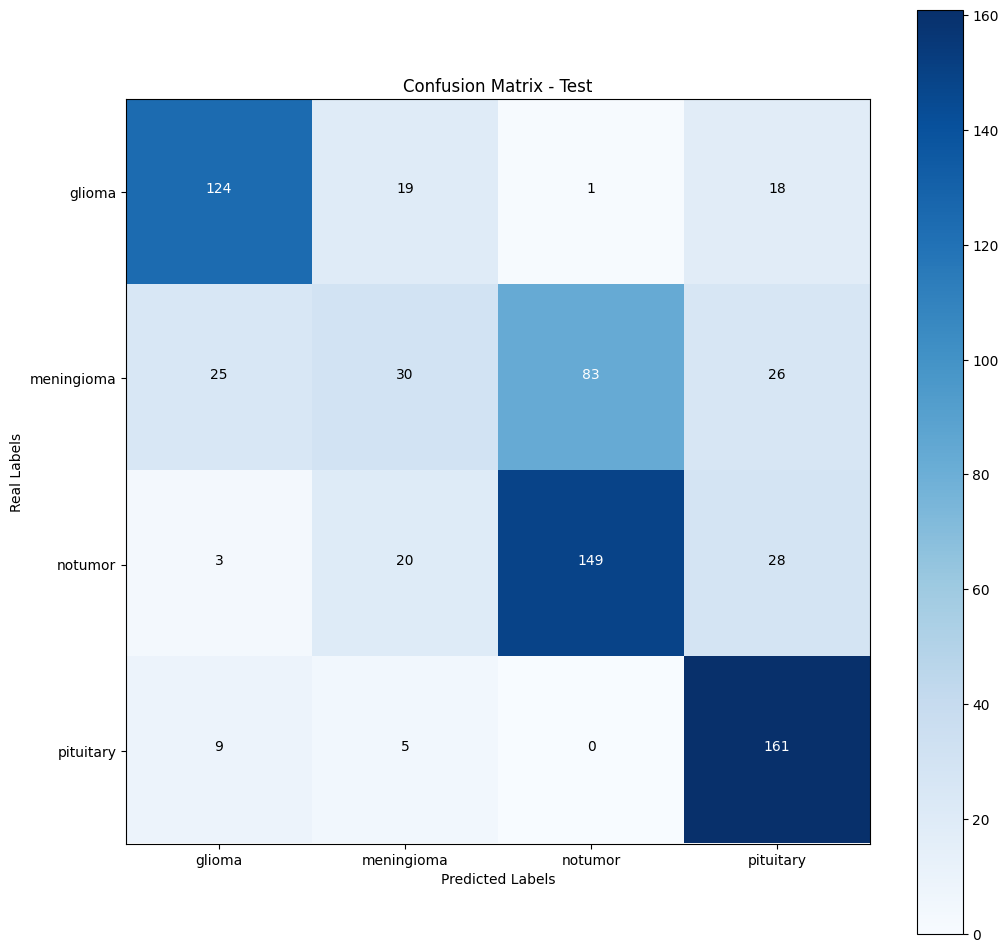

In [26]:

# Prediction : use the test set (testing_set)
import tensorflow as tf
import itertools
import numpy as np

predictions = model.predict(testing_set)
y_pred = np.argmax(predictions, axis = 1)
#y_test = np.argmax(testing_set.classes, axis = 1)

labels = testing_set.class_indices
#labels = ['BNE', 'BA', 'EO','ERB','LY','MMY','MO','MY','PLT','PMY','SNE']
title = "Test"

# Calculate and display the confucsion matrix
cnf_matrix = confusion_matrix(testing_set.classes, y_pred)
# cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')

# cnf_matrix = confusion_matrix(tf.argmax(testing_set.classes, axis = 1), y_pred, normalize = 'true')

classes = range(len(labels))


plt.figure(figsize = (12,12))
plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion Matrix - "+title)
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i, j in itertools.product(range(cnf_matrix.shape[0]),
                                range(cnf_matrix.shape[1])):
  plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Real Labels')
plt.xlabel('Predicted Labels')
plt.show()


## Classification_Report

In [27]:
from sklearn.metrics import classification_report
print(classification_report(testing_set.classes, y_pred,target_names = labels))

              precision    recall  f1-score   support

      glioma       0.77      0.77      0.77       162
  meningioma       0.41      0.18      0.25       164
     notumor       0.64      0.74      0.69       200
   pituitary       0.69      0.92      0.79       175

    accuracy                           0.66       701
   macro avg       0.63      0.65      0.62       701
weighted avg       0.63      0.66      0.63       701



## Visualization of Model

## Install tf.keras.vis

In [28]:
!pip install tf-keras-vis tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 958.0 kB/s eta 0:00:00


## Import Libraries

In [29]:
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


## Load and preprocess images

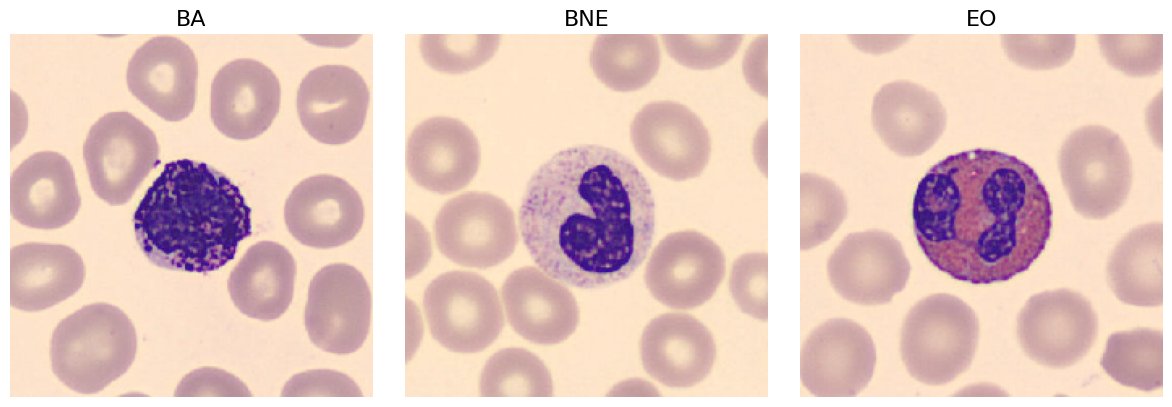

In [ ]:
# Image titles
image_titles = ['BA', 'BNE', 'EO']

# Load images and Convert them to a Numpy array
img1 = load_img('/content/drive/MyDrive/Images/BA.jpg', target_size=(224, 224))
img2 = load_img('/content/drive/MyDrive/Images/BNE.jpg', target_size=(224, 224))
img3 = load_img('/content/drive/MyDrive/Images/EO.jpg', target_size=(224, 224))

images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Model modifier

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

## Score function

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0,1,2])


## ScoreCAM

48/48 [==============================] - 6s 112ms/step


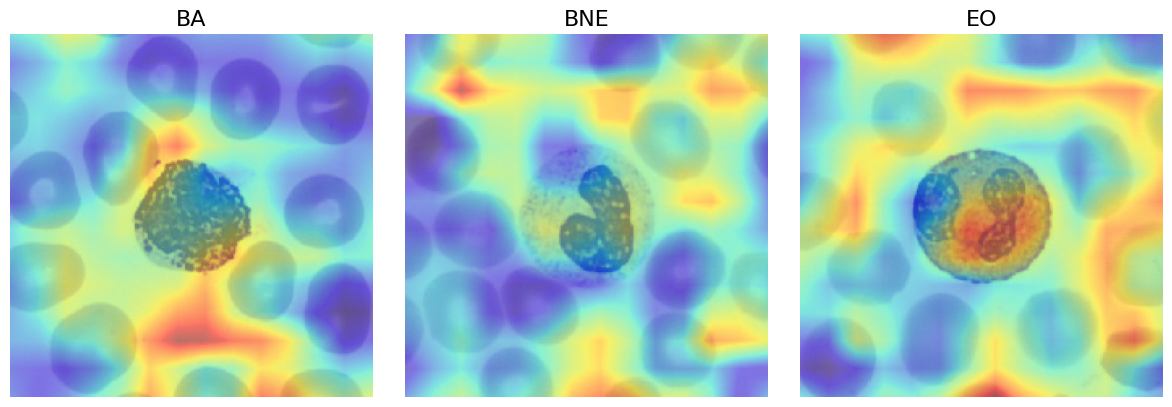

CPU times: user 30.6 s, sys: 3.61 s, total: 34.3 s
Wall time: 38.9 s


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
#cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

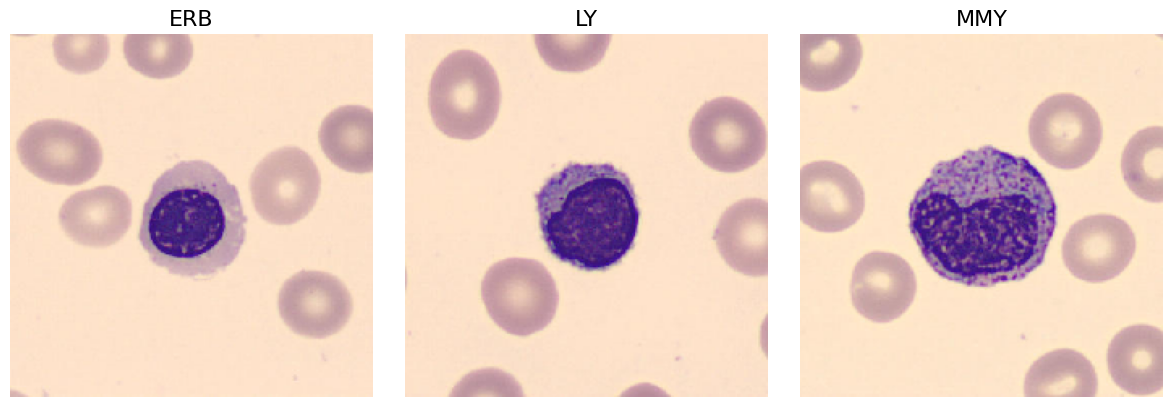

In [ ]:
# Image titles
image_titles = ['ERB', 'LY', 'MMY']

# Load images and Convert them to a Numpy array
img1 = load_img('/content/drive/MyDrive/Images/ERB.jpg', target_size=(224, 224))
img2 = load_img('/content/drive/MyDrive/Images/LY.jpg', target_size=(224, 224))
img3 = load_img('/content/drive/MyDrive/Images/MMY.jpg', target_size=(224, 224))

images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([3,4,5])


48/48 [==============================] - 5s 113ms/step


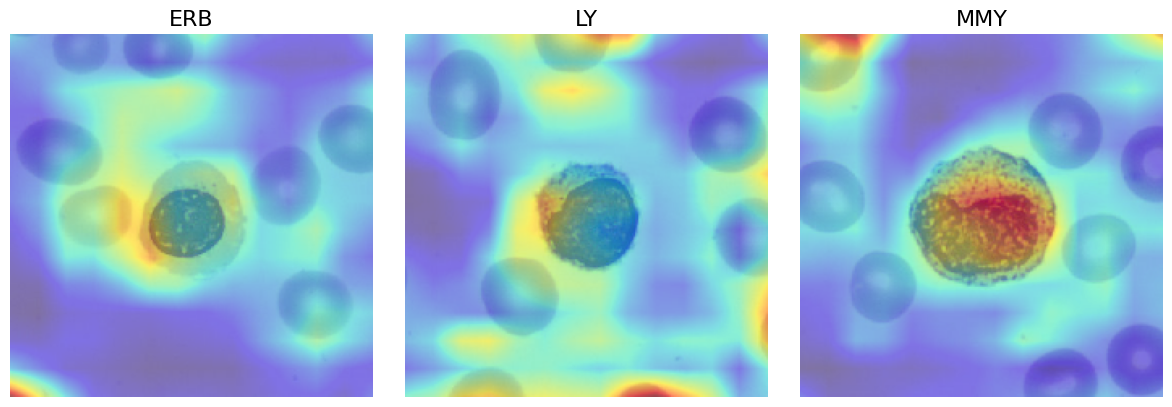

CPU times: user 25.6 s, sys: 3.01 s, total: 28.6 s
Wall time: 33.3 s


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
#cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()